In [1]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)

<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

In [4]:
product_list = ["IF", "IH", "IC", "T", "TF"]

In [5]:
period = 4096

In [6]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days
## 1092

1092

In [7]:
import dask
from dask import compute, delayed
import sklearn.preprocessing


- it may affect previous result but the result is still accpetable

In [8]:
train_sample = all_dates<"2018"
test_sample = all_dates>"2018"
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

In [9]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
signal_list = [signal+".4096" for signal in all_signal_list]
np.append(signal_list, ["ret.4096", "ret.4096.001", "ret.4096.002"])
n_signal = len(signal_list)

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import lasso_path, LassoCV
from sklearn.preprocessing import StandardScaler
y_signal = "ret."+str(period)+".004"


- we can load xgboost and lightgbm at first

In [11]:
import xgboost as xgb
import lightgbm as lgb
import os

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [13]:
ori_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
signal_names = ori_mat.columns[0:-3]
signal_names
col_names = ori_mat.columns

In [14]:
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")

print(product_list[0], train_mat.shape)
for product in product_list[1:3]:
    cur_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    cur_mat = pd.DataFrame(data=sklearn.preprocessing.scale(cur_mat, with_mean=False), columns=col_names)
    print(product, cur_mat.shape)
    train_mat = train_mat.append(cur_mat)

# IF (2045, 49)
# IH (1431, 49)
# IC (2048, 49)


IF (2045, 49)
IH (1431, 49)
IC (2048, 49)


In [15]:
train_std_mat = dict([])
train_mat = load(HEAD_PATH+"/train test mat/"+product_list[0]+".train.mat.pkl")
train_mat = train_mat[0:0]
test_mat = train_mat
for product in product_list[:3]:
    cur_train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    train_std_mat[product] = np.std(cur_train_mat)
    train_mat = train_mat.append(cur_train_mat/train_std_mat[product])
    cur_test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    test_mat = test_mat.append(cur_test_mat/train_std_mat[product])

In [16]:
print(train_mat.shape)
print(test_mat.shape)

# (5524, 49)
# (9251, 49)




(5524, 49)
(9251, 49)


In [17]:
x_train = train_mat.iloc[:, :n_signal].values
y_train = train_mat.loc[:, y_signal].values

In [19]:
strat = "gbm.4096"

- create a directory for the first strate

In [20]:
for product in product_list:
    os.makedirs("e:/intern"+"/tmp pkl/"+product+"/"+strat, exist_ok=True)

In [21]:
gb1 = GradientBoostingRegressor(random_state=0)
param_grid = {
        'n_estimators': np.arange(10,200,10),
        'max_depth': [3,4,5,6,7,8,9,10],
        'learning_rate':[0.01,0.1],
        'min_samples_leaf': [10,20], 
    
}


In [22]:
%%time
gbm1 = GridSearchCV(gb1, param_grid, n_jobs=CORE_NUM, cv=5);
gbm1.fit(x_train, y_train);
# Wall time: 29min 17s





Wall time: 29min 17s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [23]:
x_train.shape

(5524, 45)

In [25]:
print('Gradient boosted tree regression...')
print('Best Params:')
print(gbm1.best_params_)
print('Best CV Score:')
print(gbm1.best_score_)
save(gbm1, HEAD_PATH+"/index.gbm.4096.pkl")
# Gradient boosted tree regression...
# Best Params:
# {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 20, 'n_estimators': 40}
# Best CV Score:
# 0.001769038868692521





Gradient boosted tree regression...
Best Params:
{'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 20, 'n_estimators': 40}
Best CV Score:
0.001769038868692521


In [26]:
%%time
for product in product_list[:3]:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=gbm1, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
;
# Wall time: 24min 5s


Wall time: 24min 5s


''

In [27]:
signal_name = strat
SAVE_PATH = "e:/intern"
print(strat)

gbm.4096


In [29]:
%%time
for product in product_list[0:3]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")

## Wall time: 2min 25s

Wall time: 2min 25s


In [30]:
%%time
for product in product_list[0:3]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("gbm", all_dates, product, 2, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2018", tranct=tranct, 
                    max_spread=spread+0.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# Wall time: 8min 26s



reverse=1
reverse=1
reverse=1
Wall time: 8min 26s


IF train sharpe  0.4832430170458094 test sharpe  0.2983703814089415
IC train sharpe  0.41217571806037334 test sharpe  1.4127392902644593
train sharpe:  0.5424312794946722 test sharpe:  1.2711659663574644


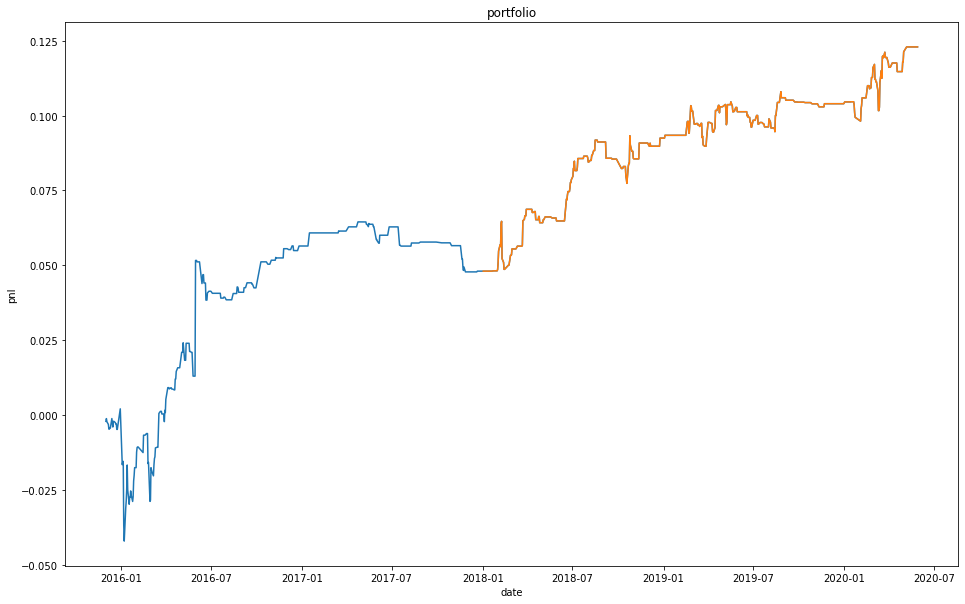

In [36]:
i = 0
strat = "gbm.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
min_pnl = 10
min_num = 10
for product in product_list[0:3]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if (sum(good_strat)>0):
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
        i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# IF train sharpe  0.4832430170458094 test sharpe  0.2983703814089415
# IC train sharpe  0.41217571806037334 test sharpe  1.4127392902644593
# train sharpe:  0.5424312794946722 test sharpe:  1.2711659663574644

    

- now we can go on with rolling gbm model
- it's added this term of course

In [37]:
month = np.array([file[:6] for file in all_dates])
month_len = np.unique(month, return_counts=True)

In [39]:
## rolling model for gradient boosting machine
## returned value is the training sample standard deviation and the final model
def get_multiple_gbm_roll_model(train_start, train_end, y_signal, forward_len, strat, 
                          product_list, period=4096, SAVE_PATH="e:/intern"):
    cum_daily_ticks = dict([])
    train_tick_start = dict([])
    train_tick_end = dict([])   
    test_tick_start = dict([])
    test_tick_end = dict([])
    scaler =  StandardScaler(copy=True, with_mean=False, with_std=True)
    for product in product_list:
        cum_daily_ticks[product] = daily_ticks[product].cumsum()
        if train_start==0:
            train_tick_start[product] = 0
        else:
            train_tick_start[product] = int(cum_daily_ticks[product][train_start-1]+1)
        train_tick_end[product] = int(cum_daily_ticks[product][train_end]-1)
        test_tick_start[product] = int(train_tick_end[product]+2)
        test_tick_end[product] = int(cum_daily_ticks[product][train_end+1])
    coef_list = dict([])
    gb1 = GradientBoostingRegressor(random_state=0)
    gb1 = GradientBoostingRegressor(random_state=0)
    param_grid = {
            'n_estimators': np.arange(10,100,10),
            'max_depth': [3,4,5,6,7,8],
            'learning_rate':[0.01],
            'min_samples_leaf': [20], 
    }
    model = GridSearchCV(gb1, param_grid, n_jobs=CORE_NUM, cv=5);
    train_std_mat = dict([])
    train_mat = np.zeros((0,n_signal))
    y_train = np.array([])
    for product in product_list:
        x_train = all_mat[product].iloc[train_tick_start[product]:train_tick_end[product], :n_signal].values
        cur_y_train = all_mat[product][y_signal][train_tick_start[product]:train_tick_end[product]]
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        train_std_mat[product] = np.sqrt(scaler.var_)
        train_mat = np.append(train_mat,x_train, axis=0)
        y_train = np.append(y_train, cur_y_train)
    model.fit(train_mat, y_train);
    os.makedirs(SAVE_PATH+"/model", exist_ok=True)
    save([train_std_mat, model], SAVE_PATH+"/model/"+strat+".pkl")
    


In [40]:
test_range = np.where(month_len[0] > "2018" )[0]
print(month_len[0][test_range])
start_month = 0
end_month = sum(month_len[0] < "2018")-1
cum_month_len = np.cumsum(month_len[1])

# ['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
#  '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
#  '201905' '201906' '201907' '201908' '201909' '201910' '201911' '201912'
#  '202001' '202002' '202003' '202004' '202005']



['201801' '201802' '201803' '201804' '201805' '201806' '201807' '201808'
 '201809' '201810' '201811' '201812' '201901' '201902' '201903' '201904'
 '201905' '201906' '201907' '201908' '201909' '201910' '201911' '201912'
 '202001' '202002' '202003' '202004' '202005']


In [41]:
daily_ticks = dict([])
all_mat = dict([])
for product in product_list:
    daily_num = load(HEAD_PATH+"/daily num/"+product+".pkl")
    daily_ticks[product] = daily_num
    test_mat = load(HEAD_PATH+"/train test mat/"+product+".test.mat.pkl")
    train_mat = load(HEAD_PATH+"/train test mat/"+product+".train.mat.pkl")
    all_mat[product] = pd.concat((train_mat, test_mat))

In [42]:
%%time
strat = "gbm.4096"
y_signal = "ret.4096.004"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    get_multiple_gbm_roll_model(train_start, train_end, y_signal, forward_len, strat+"."+month_len[0][i_test], 
                          product_list, period=4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# 48 201912
# 49 202001
# 50 202002
# Wall time: 1h 38min 40s


25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
48 201912
49 202001
50 202002
51 202003
52 202004
53 202005
Wall time: 1h 12min 21s


- now we can generate values of each model

In [43]:
%%time
start_month = 0
SAVE_PATH = "e:/intern"
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(i_test, month_len[0][i_test])
    strat_name = strat+"."+month_len[0][i_test]
    train_std_mat, model = load(SAVE_PATH+"/model/"+strat_name+".pkl")
    for product in product_list:
        os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat_name, exist_ok=True)
        parLapply(CORE_NUM,all_dates[train_start:(train_end+forward_len+1)], get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=model, strat=strat_name, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
    start_month = start_month+1
    end_month = end_month+1

# 25 201801
# 26 201802
# 27 201803
# 28 201804
# 29 201805
# 30 201806
# 31 201807
# 32 201808
# 33 201809
# 34 201810
# 35 201811
# 36 201812
# 37 201901
# 38 201902
# 39 201903
# 40 201904
# 41 201905
# 42 201906
# 43 201907
# 44 201908
# 45 201909
# 46 201910
# 47 201911
# 48 201912
# 49 202001
# 50 202002
# Wall time: 5h 57min 44s


25 201801
26 201802
27 201803
28 201804
29 201805
30 201806
31 201807
32 201808
33 201809
34 201810
35 201811
36 201812
37 201901
38 201902
39 201903
40 201904
41 201905
42 201906
43 201907
44 201908
45 201909
46 201910
47 201911
48 201912
49 202001
50 202002
51 202003
52 202004
53 202005
Wall time: 6h 15min 39s


In [45]:
%%time
strat = "gbm.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
for i_test in test_range:
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    print(month_len[0][i_test], all_dates[train_start], all_dates[train_end])
    for product in product_list[0:3]:
        par_get_all_signal(strat+"."+month_len[0][i_test], all_dates[train_start:(train_end+1)], product, 4096, SAVE_PATH="e:/intern")
    start_month = start_month+1
    end_month = end_month+1

# 201801 20151202.pkl 20171229.pkl
# 201802 20160104.pkl 20180131.pkl
# 201803 20160201.pkl 20180228.pkl
# 201804 20160301.pkl 20180330.pkl
# 201805 20160401.pkl 20180427.pkl
# 201806 20160503.pkl 20180531.pkl
# 201807 20160601.pkl 20180629.pkl
# 201808 20160701.pkl 20180731.pkl
# 201809 20160801.pkl 20180831.pkl
# 201810 20160901.pkl 20180928.pkl
# 201811 20161010.pkl 20181031.pkl
# 201812 20161101.pkl 20181130.pkl
# 201901 20161201.pkl 20181228.pkl
# 201902 20170103.pkl 20190131.pkl
# 201903 20170203.pkl 20190228.pkl
# 201904 20170301.pkl 20190329.pkl
# 201905 20170405.pkl 20190430.pkl
# 201906 20170502.pkl 20190531.pkl
# 201907 20170601.pkl 20190628.pkl
# 201908 20170703.pkl 20190731.pkl
# 201909 20170801.pkl 20190830.pkl
# 201910 20170901.pkl 20190930.pkl
# 201911 20171009.pkl 20191031.pkl
# 201912 20171101.pkl 20191129.pkl
# 202001 20171201.pkl 20191231.pkl
# 202002 20180102.pkl 20200123.pkl
# Wall time: 6min 39s


201801 20151202.pkl 20171229.pkl
201802 20160104.pkl 20180131.pkl
201803 20160201.pkl 20180228.pkl
201804 20160301.pkl 20180330.pkl
201805 20160401.pkl 20180427.pkl
201806 20160503.pkl 20180531.pkl
201807 20160601.pkl 20180629.pkl
201808 20160701.pkl 20180731.pkl
201809 20160801.pkl 20180831.pkl
201810 20160901.pkl 20180928.pkl
201811 20161010.pkl 20181031.pkl
201812 20161101.pkl 20181130.pkl
201901 20161201.pkl 20181228.pkl
201902 20170103.pkl 20190131.pkl
201903 20170203.pkl 20190228.pkl
201904 20170301.pkl 20190329.pkl
201905 20170405.pkl 20190430.pkl
201906 20170502.pkl 20190531.pkl
201907 20170601.pkl 20190628.pkl
201908 20170703.pkl 20190731.pkl
201909 20170801.pkl 20190830.pkl
201910 20170901.pkl 20190930.pkl
201911 20171009.pkl 20191031.pkl
201912 20171101.pkl 20191129.pkl
202001 20171201.pkl 20191231.pkl
202002 20180102.pkl 20200123.pkl
202003 20180201.pkl 20200228.pkl
202004 20180301.pkl 20200331.pkl
202005 20180402.pkl 20200430.pkl
Wall time: 7min 11s


In [46]:
def get_roll_result(product, strat,test_range, month_len, atr_filter=0, save_path="signal result atr", 
                          HEAD_PATH="d:/intern", SIGNAL_PATH="e:/intern"):
    start_month = 0
    end_month = sum(month_len[0] < "2018")-1
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    spread = product_info[product]["spread"]
    for i_test in test_range:
        forward_len = month_len[1][i_test]
        train_start = 0 if start_month==0 else cum_month_len[start_month-1]
        train_end = cum_month_len[end_month]-1
        strat_name = strat+"."+month_len[0][i_test]
        print(product, i_test, strat_name)
        all_signal = load(SIGNAL_PATH+"/all signal/"+product+"."+strat_name+".pkl")
        open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
        thre_list = []
        for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
            thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
        thre_list = np.array(thre_list)
        thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
        train_result = parLapply(CORE_NUM, all_dates[train_start:(train_end+1)], get_signal_pnl, 
                             product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        train_stat = get_hft_summary(train_result, thre_mat, train_end-train_start+1)
        test_result = parLapply(CORE_NUM, all_dates[(train_end+1):(train_end+forward_len+1)], get_signal_pnl, 
                            product=product, signal_name=strat_name, thre_mat=thre_mat, reverse=1, tranct=tranct, 
                             max_spread=spread*1.1, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SIGNAL_PATH=SIGNAL_PATH,
                            atr_filter=atr_filter, rebate=0)
        test_stat = get_hft_summary(test_result, thre_mat, forward_len)
        stat_result = OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])    
        save(stat_result, HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        start_month = start_month+1
        end_month = end_month+1


In [47]:
%%time
strat = "gbm.4096"
for product in product_list[0:3]:
    get_roll_result(product, strat, test_range, month_len, atr_filter=20)

## Wall time: 3h 8min 45s

IF 25 gbm.4096.201801
IF 26 gbm.4096.201802
IF 27 gbm.4096.201803
IF 28 gbm.4096.201804
IF 29 gbm.4096.201805
IF 30 gbm.4096.201806
IF 31 gbm.4096.201807
IF 32 gbm.4096.201808
IF 33 gbm.4096.201809
IF 34 gbm.4096.201810
IF 35 gbm.4096.201811
IF 36 gbm.4096.201812
IF 37 gbm.4096.201901
IF 38 gbm.4096.201902
IF 39 gbm.4096.201903
IF 40 gbm.4096.201904
IF 41 gbm.4096.201905
IF 42 gbm.4096.201906
IF 43 gbm.4096.201907
IF 44 gbm.4096.201908
IF 45 gbm.4096.201909
IF 46 gbm.4096.201910
IF 47 gbm.4096.201911
IF 48 gbm.4096.201912
IF 49 gbm.4096.202001
IF 50 gbm.4096.202002
IF 51 gbm.4096.202003
IF 52 gbm.4096.202004
IF 53 gbm.4096.202005
IH 25 gbm.4096.201801
IH 26 gbm.4096.201802
IH 27 gbm.4096.201803
IH 28 gbm.4096.201804
IH 29 gbm.4096.201805
IH 30 gbm.4096.201806
IH 31 gbm.4096.201807
IH 32 gbm.4096.201808
IH 33 gbm.4096.201809
IH 34 gbm.4096.201810
IH 35 gbm.4096.201811
IH 36 gbm.4096.201812
IH 37 gbm.4096.201901
IH 38 gbm.4096.201902
IH 39 gbm.4096.201903
IH 40 gbm.4096.201904
IH 41 gbm.

sharpe  0.19856018913586373


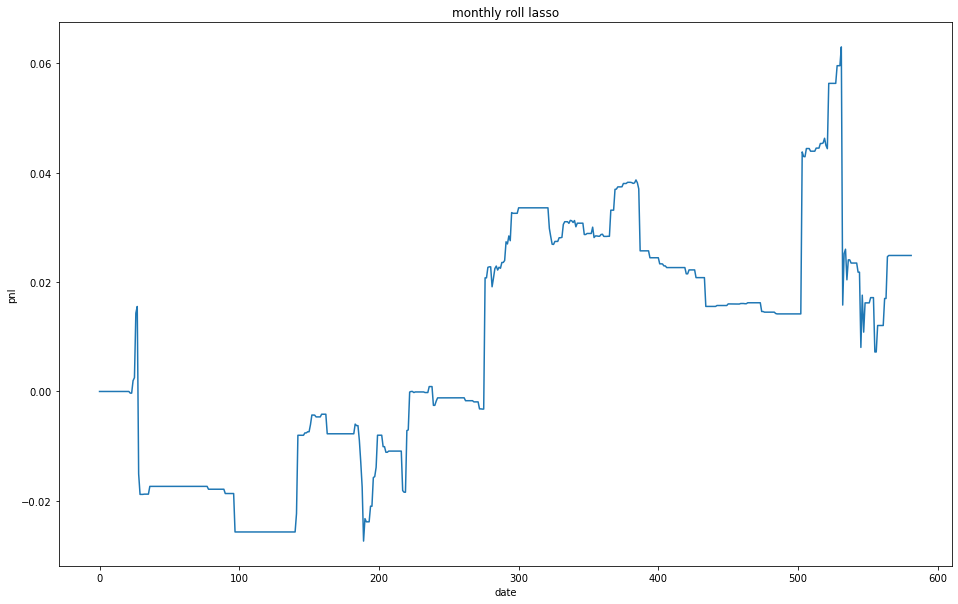

In [49]:
n_product = len(product_list[0:3])
save_path = "signal result atr"
strat = "gbm.4096"
start_month = 0
end_month = sum(month_len[0] < "2018")-1
all_pnl = np.array([])
for i_test in test_range:
    forward_len = month_len[1][i_test]
    train_start = 0 if start_month==0 else cum_month_len[start_month-1]
    train_end = cum_month_len[end_month]-1
    strat_name = strat+"."+month_len[0][i_test]
    train_mat = np.zeros((train_end-train_start+1, n_product))
    test_mat = np.zeros((forward_len, n_product))
    for i_product in range(n_product):
        product = product_list[i_product]
        stat_result = load(HEAD_PATH+"/"+save_path+"/"+product+"."+strat_name+".pkl")
        train_stat = stat_result["train.stat"]
        test_stat = stat_result["test.stat"]
        spread = product_info[product]["spread"]
        good_strat = (train_stat["final.result"]["avg.pnl"]>10*spread)
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat) 
        train_pnl[np.isnan(train_pnl)]=0
        train_mat[:,i_product] = train_pnl
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_pnl[np.isnan(test_pnl)]=0
        test_mat[:,i_product] = test_pnl
    sharpe_mat = np.apply_along_axis(sharpe, 0, train_mat)
    sharpe_weight = zero_divide(sharpe_mat, np.sum(sharpe_mat))
    #parity_weight = risk_parity(train_mat)
    #diagonal_weight = risk_parity(train_mat, only_diag=True)
    #avg_test_pnl = test_mat.mean(axis=1)
    avg_test_pnl = np.dot(test_mat, sharpe_weight)
    #avg_test_pnl = np.dot(test_mat, parity_weight)
    #avg_test_pnl = np.dot(test_mat, diagonal_weight)
    all_pnl = np.append(all_pnl, avg_test_pnl)
    start_month = start_month+1
    end_month = end_month+1
plt.figure(1, figsize=(16, 10))
plt.title("monthly roll lasso")
plt.xlabel("date")
plt.ylabel("pnl")
plt.plot(all_pnl.cumsum());
print("sharpe ", sharpe(all_pnl))

## sharpe 0.19856018913586373



- Now let's start with xgboost

In [50]:
import xgboost as xgb

- we need to create specific train and test data sets for xgboost

In [51]:
cv_params = {'max_depth': [3,4,5,6,7,8,9,10], 
             'n_estimators': np.arange(10,200,10)}
ind_params = {'learning_rate': 0.1,
              "min_samples_leaf":[10,20],
              'seed':100, 'objective': 'reg:linear'}
xgb_cv = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                            cv_params, 
                            cv = 5, n_jobs = -1) 

In [52]:
%%time
xgb_cv.fit(x_train, y_train);

# Wall time: 9min 30s

# GridSearchCV(cv=5, error_score='raise-deprecating',
#              estimator=XGBRegressor(base_score=0.5, booster='gbtree',
#                                     colsample_bylevel=1, colsample_bytree=1,
#                                     gamma=0, importance_type='gain',
#                                     learning_rate=0.1, max_delta_step=0,
#                                     max_depth=3, min_child_weight=1,
#                                     min_samples_leaf=[10, 20], missing=None,
#                                     n_estimators=100, n_jobs=1, nthread=None,
#                                     objective='reg:linear', random_state=0,
#                                     reg_alpha=0, reg_lambda=1,
#                                     scale_pos_weight=1, seed=100, silent=True,
#                                     subsample=1),
#              iid='warn', n_jobs=-1,
#              param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#                          'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
#        140, 150, 160, 170, 180, 190])},
#              pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
#              scoring=None, verbose=0)

Wall time: 9min 30s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    min_samples_leaf=[10, 20], missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=100, silent=True,
                                    subsample=1),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': array([ 10,  20,  30,  40

In [53]:
#best_parameters, score, _ = max(xgb_cv.grid_scorer, key=lambda x: x[1])
xgb_cv.best_params_
## {'max_depth': 3, 'n_estimators': 20}

{'max_depth': 3, 'n_estimators': 20}

In [57]:
strat = "xgb.index.4096"
signal_name = strat

In [58]:
SAVE_PATH = "e:/intern"
for product in product_list:
    os.makedirs(SAVE_PATH+"/tmp pkl/"+product+"/"+strat, exist_ok=True)


- we can plot them to check the result

In [59]:
%%time
for product in product_list[0:3]:
    parLapply(CORE_NUM, all_dates, get_daily_gbm, 
          product=product, signal_list=signal_list, 
          model=xgb_cv, strat=strat, HEAD_PATH=HEAD_PATH, SAVE_PATH="e:/intern", train_std=np.array(train_std_mat[product][:n_signal]))
;
# Wall time: 23min 20s


Wall time: 23min 20s


''

In [60]:
%%time
for product in product_list[0:3]:
    par_get_all_signal(strat, all_dates, product, 4096, SAVE_PATH="e:/intern")
    
#  Wall time: 1min 1s


Wall time: 42.1 s


In [62]:
%%time
for product in product_list[0:3]:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    evaluate_signal("xgb.index", all_dates, product, 10, 20, CORE_NUM, HEAD_PATH, SAVE_PATH,
                    period=4096, split_str="2018", tranct=tranct, 
                    max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20, save_path="signal result atr",reverse=1)

# reverse=1
# reverse=1
# reverse=1
# Wall time: 8min 47s


reverse=1
reverse=1
reverse=1
Wall time: 8min 47s


IF train sharpe  0.27315546737391305 test sharpe  0.31311520562906986
IH train sharpe  0.36267660381586125 test sharpe  0.7779509367252966
IC train sharpe  0.7327980584582787 test sharpe  0.4972038999082831
train sharpe:  0.5879259984932361 test sharpe:  0.7164349811569111


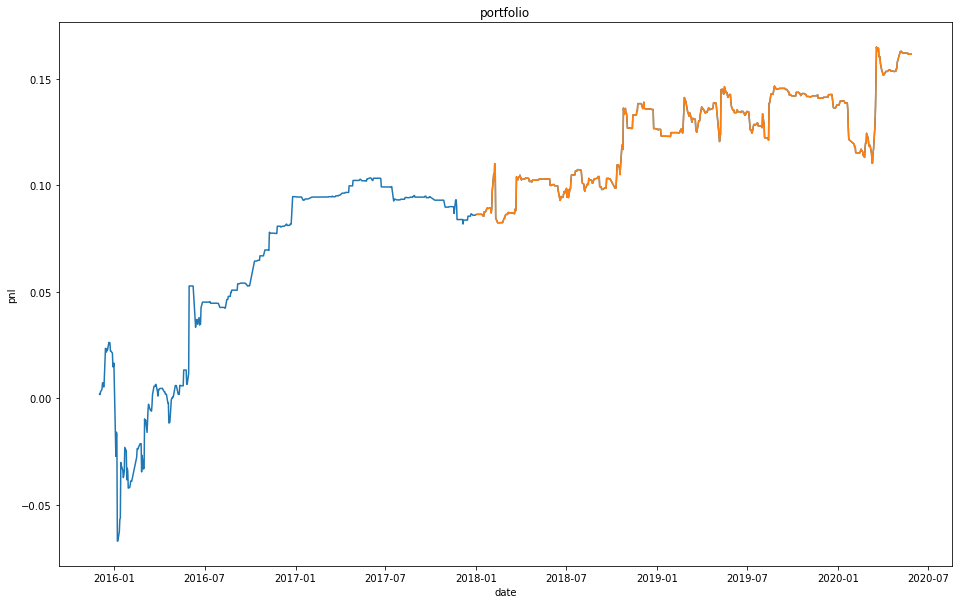

In [63]:
i = 0
strat = "xgb.index.4096"
test_all_pnl = np.zeros([sum(test_sample), len(product_list[0:3])])
train_all_pnl = np.zeros([sum(train_sample), len(product_list[0:3])])
min_pnl = 2
min_num = 10
for product in product_list[0:3]:
    spread = product_info[product]["spread"]
    signal_stat = load(HEAD_PATH+"/signal result atr/"+product+"."+strat+".trend.pkl")
    train_stat = signal_stat["train.stat"]
    good_strat = (train_stat["final.result"]["avg.pnl"]>min_pnl*spread) & (train_stat["final.result"]["num"]>min_num)
    if sum(good_strat)>0:
        train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        test_stat = signal_stat["test.stat"]
        test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
        print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
        test_all_pnl[:,i] = test_pnl
        train_all_pnl[:,i] = train_pnl
    else:
        train_pnl = np.zeros(np.shape(train_stat["daily.ret"])[0])
        test_stat = signal_stat["test.stat"]
        test_pnl = np.zeros(np.shape(test_stat["daily.ret"])[0])
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe: ", sharpe(train_portfolio), "test sharpe: ", sharpe(test_portfolio))    

# IF train sharpe  0.27315546737391305 test sharpe  0.31311520562906986
# IH train sharpe  0.36267660381586125 test sharpe  0.7779509367252966
# IC train sharpe  0.7327980584582787 test sharpe  0.4972038999082831
# train sharpe:  0.5879259984932361 test sharpe:  0.7164349811569111



- SUMMARY


- today we compare two tree-based models: gradient boosting machine and xgboost
- but the result is pretty bad
- you can try to tune the parameter to see whether we could improve it